# Result analysis

## Imports and data loading

In [12]:
import xarray as xr

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

import xskillscore as xs
import pandas as pd


import re
import skill_metrics as sm

import matplotlib.lines as mlines

from matplotlib.colors import TwoSlopeNorm

import cartopy.crs as ccrs
from pyproj import CRS

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.feature as cfeature
from pyproj import Transformer
import matplotlib.ticker as mticker

In [13]:
results = xr.open_dataset('results_2022_ws_gcshifted_meso_gc.nc')
synop = xr.open_dataset('synop_filtered.nc')

synop = synop.sel(station=['06201', '06203', '06204', '06207', '06208', '06211', '06214', '06215',
            '06225', '06229', '06235', '06240', '06242', '06248', '06249', '06251',
            '06257', '06258', '06260', '06267', '06269', '06270', '06273', '06275',
            '06277', '06278', '06279', '06280', '06283', '06286', '06290', '06310',
            '06317', '06319', '06323', '06330', '06340', '06343', '06344', '06348',
            '06350', '06356', '06370', '06375', '06377', '06380', '06212'])

synop

<xarray.Dataset> Size: 31MB
Dimensions:      (time: 1362, station: 47)
Coordinates:
  * station      (station) <U5 940B '06201' '06203' '06204' ... '06380' '06212'
  * time         (time) datetime64[ns] 11kB 2022-01-12 ... 2022-12-31T18:00:00
Data variables: (12/51)
    stationname  (time, station) <U22 6MB ...
    lat          (time, station) float64 512kB ...
    lon          (time, station) float64 512kB ...
    height       (time, station) float64 512kB ...
    dd           (station, time) float64 512kB ...
    ff           (station, time) float64 512kB ...
    ...           ...
    ww-10        (station, time) float64 512kB ...
    ts1          (station, time) float64 512kB ...
    ts2          (station, time) float64 512kB ...
    iso_dataset  (time, station) |S8 512kB ...
    product      (time, station) |S8 512kB ...
    projection   (time, station) |S8 512kB ...
Attributes:
    featureType:  timeSeries
    Conventions:  CF-1.4
    title:        KMDS__OPER_P___10M_OBS_L2
    institution:  Royal Netherlands Meteorological Institute (KNMI)
    source:       Royal Netherlands Meteorological Institute (KNMI)
    history:      File created from KMDS ASCII file. 
    references:   http://data.knmi.nl
    comment:      Please note: no data has been found for the following varia...

### Statistic functions

In [14]:
def plot_stations_with_metric(synop_data, metric_dict=None, metric_label=None, variable_name=None, marker_size=50, save_path=None):
    """
    Function to plot weather stations and color them based on a given metric for 4 different models.
    
    Parameters:
    - synop_data (xarray.Dataset): Dataset containing the station data with latitude, longitude, and station name.
    - metric_dict (dict): Dictionary with keys as model names and values as metrics to be plotted for each model.
    - metric_label (str, optional): Label for the color bar, describing the metric. Default is None.
    - variable_name (str, optional): Name of the weather variable. Default is None.
    - marker_size (int, optional): Size of the station markers. Default is 50.
    - save_path (str, optional): Path to save the figure. Default is None.
    """

    # Define the models you want to plot
    model_suffix = ['gc', 'meso', 'hres', 'analysis']

    # Extract station information
    station_lats = synop_data['lat'].isel(time=100).values
    station_lons = synop_data['lon'].isel(time=100).values
    station_names = synop_data['station'].values

    # Remove invalid lat/lon stations
    valid_mask = ~np.isnan(station_lats) & ~np.isnan(station_lons)
    station_lats = station_lats[valid_mask]
    station_lons = station_lons[valid_mask]
    station_names = station_names[valid_mask]

    # Define the latitude and longitude boundaries
    lat_min, lat_max = 40, 70
    lon_min, lon_max = -5, 16

    # Filter based on lat/lon boundaries
    valid_bounds_mask = (
        (station_lats >= lat_min) & (station_lats <= lat_max) &
        (station_lons >= lon_min) & (station_lons <= lon_max)
    )
    station_lats = station_lats[valid_bounds_mask]
    station_lons = station_lons[valid_bounds_mask]
    station_names = station_names[valid_bounds_mask]

    # Create a GeoDataFrame for the stations
    gdf_stations = gpd.GeoDataFrame(
        {'Station': station_names},
        geometry=[Point(lon, lat) for lon, lat in zip(station_lons, station_lats)],
        crs="EPSG:4326"
    )

    # Load shapefiles for the Netherlands and provinces
    world = gpd.read_file("/home/koenr/thesis_code/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
    netherlands = world[(world.SOVEREIGNT == "Netherlands") & (world.CONTINENT == "Europe")].to_crs(epsg=28992)
    
    provinces = gpd.read_file("/home/koenr/thesis_code/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
    netherlands_provinces = provinces[provinces['adm1_code'].str.startswith('NLD')].to_crs(epsg=28992)

    # Reproject stations to EPSG:28992
    gdf_stations = gdf_stations.to_crs(epsg=28992)

    # Calculate global min and max for consistent colorbar scaling across all models
    all_metrics = np.concatenate([metric_dict[model] for model in model_suffix if metric_dict.get(model) is not None])
    vmin, vmax = np.nanmin(all_metrics), np.nanmax(all_metrics)

    # Define colormap preferences based on error type
    if metric_label in ['rmse', 'mae']:
        color_map = 'magma'  # Choose a sequential colormap for error magnitude
        norm = None
    elif metric_label == 'bias':
        color_map = 'seismic'  # Diverging colormap centered at zero
        norm = TwoSlopeNorm(vmin=-max(abs(vmin), abs(vmax)), vcenter=0, vmax=max(abs(vmin), abs(vmax)))
    else:
        color_map = 'viridis'  # Default colormap
        norm = None

    # Create 4 subplots for the 4 models
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()

    for i, model in enumerate(model_suffix):
        ax = axes[i]

        # Use the corresponding metric for each model
        metric = metric_dict.get(model, None)

        # Update GeoDataFrame with metric
        gdf_stations['Metric'] = metric if metric is not None else np.nan

        # Plot the Netherlands with province boundaries
        netherlands.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
        netherlands_provinces.plot(ax=ax, color='none', edgecolor='blue', linewidth=0.25)

        # Plot the stations with color based on the metric
        if metric is not None:
            gdf_stations.plot(ax=ax, column='Metric', cmap=color_map, marker='^', markersize=marker_size, legend=True, vmin=vmin, vmax=vmax, norm=norm)
        else:
            gdf_stations.plot(ax=ax, color='green', marker='^', markersize=marker_size, label='Weather Stations')

        # Annotate the stations
        for idx, row in gdf_stations.iterrows():
            ax.annotate(row["Station"], xy=(row.geometry.x, row.geometry.y),
                        xytext=(3, 3), textcoords="offset points", fontsize=6)

        # Set plot limits and remove axes
        padding = 15000
        bounds = gdf_stations.total_bounds
        ax.set_xlim(bounds[0] - padding, bounds[2] + padding)
        ax.set_ylim(bounds[1] - padding - 5000, bounds[3] + padding)
        ax.set_axis_off()

        # Set the title for each subplot
        ax.set_title(f"{model.upper()}")

    # Add a main title with padding above the plots
    plt.suptitle(f"{variable_name} {metric_label} per Weather Station", x=0.56, fontsize=16)
    
    # Adjust layout to prevent overlap and leave space for suptitle
    plt.tight_layout()

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        
        # Print the path where the plot is saved
        print(f"Plot saved to {save_path}")
    else:
        plt.show()


## Map creation and spatial analysis

### Map functions

In [15]:
# Define the 'Amersfoort' projection
amersfoort_crs = CRS.from_epsg(28992)

# Create a custom Cartopy projection
class AmersfoortProjection(ccrs.Projection):
    def __init__(self, **kwargs):
        proj4_params = amersfoort_crs.to_proj4()
        super().__init__(proj4_params=proj4_params, **kwargs)
        self._threshold = 1e3  # Increase the threshold to improve rendering quality

    @property
    def boundary(self):
        # Define the boundary of the projection (optional)
        return None

    @property
    def extent(self):
        # Define the extent of the projection (optional)
        return None


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_single_forecast(results, synop_data, variable_name, model_suffix, time_index, prediction_timedelta_index, save_path=None):
    """
    Plots a single forecast for a given variable, model, and prediction time.

    Parameters:
    - results (xarray.Dataset): Dataset containing the forecasts and observations.
    - synop_data (xarray.Dataset): Dataset containing station locations.
    - variable_name (str): Name of the variable to plot.
    - model_suffix (str): Model suffix (e.g., 'gc', 'meso', 'hres', 'analysis').
    - time_index (int): Index of the initialization time in the 'time' dimension.
    - prediction_timedelta_index (int): Index of the prediction_timedelta to plot.
    - save_path (str, optional): Path to save the figure.

    """
    # Get station locations
    station_lats = synop_data['lat'].isel(time=0).values
    station_lons = synop_data['lon'].isel(time=0).values
    station_names = synop_data['station'].values

    # Since the data is already properly filtered, we don't need to remove invalid stations

    # Determine the latitude and longitude bounds from the station data
    lat_min, lat_max = station_lats.min(), station_lats.max()
    lon_min, lon_max = station_lons.min(), station_lons.max()

    # Add padding to the bounds
    lat_padding = (lat_max - lat_min) * 0.05
    lon_padding = (lon_max - lon_min) * 0.05
    lat_min -= lat_padding
    lat_max += lat_padding
    lon_min -= lon_padding
    lon_max += lon_padding

    # Create grid to interpolate onto
    grid_lon = np.linspace(lon_min, lon_max, 100)
    grid_lat = np.linspace(lat_min, lat_max, 100)
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    # Get the initialization time
    time_value = results['time'].values[time_index]

    # Get the prediction_timedelta value
    prediction_timedelta = results['prediction_timedelta'].values[prediction_timedelta_index]

    # Get the data for this time, lead time, and model
    var_name = f"{variable_name}_{model_suffix}"
    data = results[var_name].isel(time=time_index, prediction_timedelta=prediction_timedelta_index).values

    # Interpolate data to grid
    grid_data = griddata((station_lons, station_lats), data, (grid_lon, grid_lat), method='cubic')

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot data
    im = ax.pcolormesh(grid_lon, grid_lat, grid_data, transform=ccrs.PlateCarree(), shading='auto')

    # Plot station locations
    ax.scatter(station_lons, station_lats, color='black', s=20, transform=ccrs.PlateCarree(), zorder=5)

    # Add coastlines and borders
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)

    # Set extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Add title
    lead_hours = prediction_timedelta / np.timedelta64(1, 'h')
    ax.set_title(f"{model_suffix.upper()} Forecast of {variable_name} at {int(lead_hours)} hrs")

    # Add colorbar
    cb = plt.colorbar(im, ax=ax, orientation='vertical')
    cb.ax.set_ylabel(variable_name)

    # Show or save the plot
    if save_path:
        plt.savefig(save_path)
        plt.close()
        print(f"Plot saved to {save_path}")
    else:
        plt.show()


In [17]:
def plot_multiple_models(results, synop_data, variable_name, model_suffixes, time_index, prediction_timedelta_index, save_path=None):
    """
    Plots forecasts from multiple models for a given variable and prediction time.

    Parameters:
    - results (xarray.Dataset): Dataset containing the forecasts and observations.
    - synop_data (xarray.Dataset): Dataset containing station locations.
    - variable_name (str): Name of the variable to plot.
    - model_suffixes (list): List of model suffixes (e.g., ['gc', 'meso', 'hres', 'analysis']).
    - time_index (int): Index of the initialization time in the 'time' dimension.
    - prediction_timedelta_index (int): Index of the prediction_timedelta to plot.
    - save_path (str, optional): Path to save the figure.

    """
    # Get station locations
    station_lats = synop_data['lat'].isel(time=0).values
    station_lons = synop_data['lon'].isel(time=0).values
    station_names = synop_data['station'].values

    # Determine the latitude and longitude bounds from the station data
    lat_min, lat_max = station_lats.min(), station_lats.max()
    lon_min, lon_max = station_lons.min(), station_lons.max()

    # Add padding to the bounds
    lat_padding = (lat_max - lat_min) * 0.05
    lon_padding = (lon_max - lon_min) * 0.05
    lat_min -= lat_padding
    lat_max += lat_padding
    lon_min -= lon_padding
    lon_max += lon_padding

    # Create grid to interpolate onto
    grid_lon = np.linspace(lon_min, lon_max, 100)
    grid_lat = np.linspace(lat_min, lat_max, 100)
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    # Get the prediction_timedelta value
    prediction_timedelta = results['prediction_timedelta'].values[prediction_timedelta_index]
    lead_hours = prediction_timedelta / np.timedelta64(1, 'h')

    # Prepare for consistent color scaling across models
    all_data = []

    for model_suffix in model_suffixes:
        var_name = f"{variable_name}_{model_suffix}"
        data = results[var_name].isel(time=time_index, prediction_timedelta=prediction_timedelta_index).values
        all_data.append(data)

    # Compute global vmin and vmax
    vmin = np.nanmin(np.concatenate(all_data))
    vmax = np.nanmax(np.concatenate(all_data))

    # Create figure and axes
    num_models = len(model_suffixes)
    fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    if num_models == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, model_suffix in zip(axes, model_suffixes):
        var_name = f"{variable_name}_{model_suffix}"
        data = results[var_name].isel(time=time_index, prediction_timedelta=prediction_timedelta_index).values

        # Interpolate data to grid
        grid_data = griddata((station_lons, station_lats), data, (grid_lon, grid_lat), method='cubic')

        # Plot data
        im = ax.pcolormesh(grid_lon, grid_lat, grid_data, transform=ccrs.PlateCarree(), shading='auto', vmin=vmin, vmax=vmax)

        # Plot station locations
        ax.scatter(station_lons, station_lats, color='black', s=20, transform=ccrs.PlateCarree(), zorder=5)

        # Add coastlines and borders
        ax.coastlines(resolution='10m')
        ax.add_feature(cfeature.BORDERS)

        # Set extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # Add title
        ax.set_title(f"{model_suffix.upper()} at {int(lead_hours)} hrs")

    # Add a colorbar that spans all subplots
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label=variable_name)

    # Add a main title
    plt.suptitle(f"{variable_name} at {int(lead_hours)} hrs Lead Time", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])

    # Show or save the plot
    if save_path:
        plt.savefig(save_path)
        plt.close()
        print(f"Plot saved to {save_path}")
    else:
        plt.show()


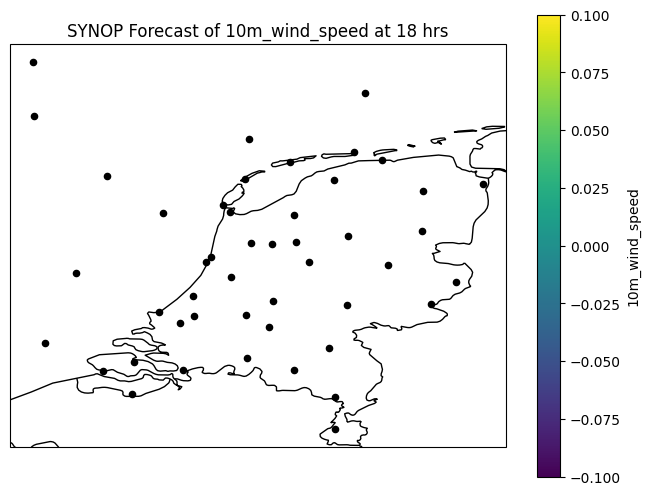

In [18]:
variable_name = '10m_wind_speed'
model_suffix = 'synop'  # Choose one of the models: 'gc', 'meso', 'hres', 'analysis'
time_index = 2  # Index of the initialization time
prediction_timedelta_index = 2  # Index of the prediction_timedelta (e.g., 0 for the first lead time)

plot_single_forecast(results, synop, variable_name, model_suffix, time_index, prediction_timedelta_index, save_path=None)


/tmp/ipykernel_424108/2818472439.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


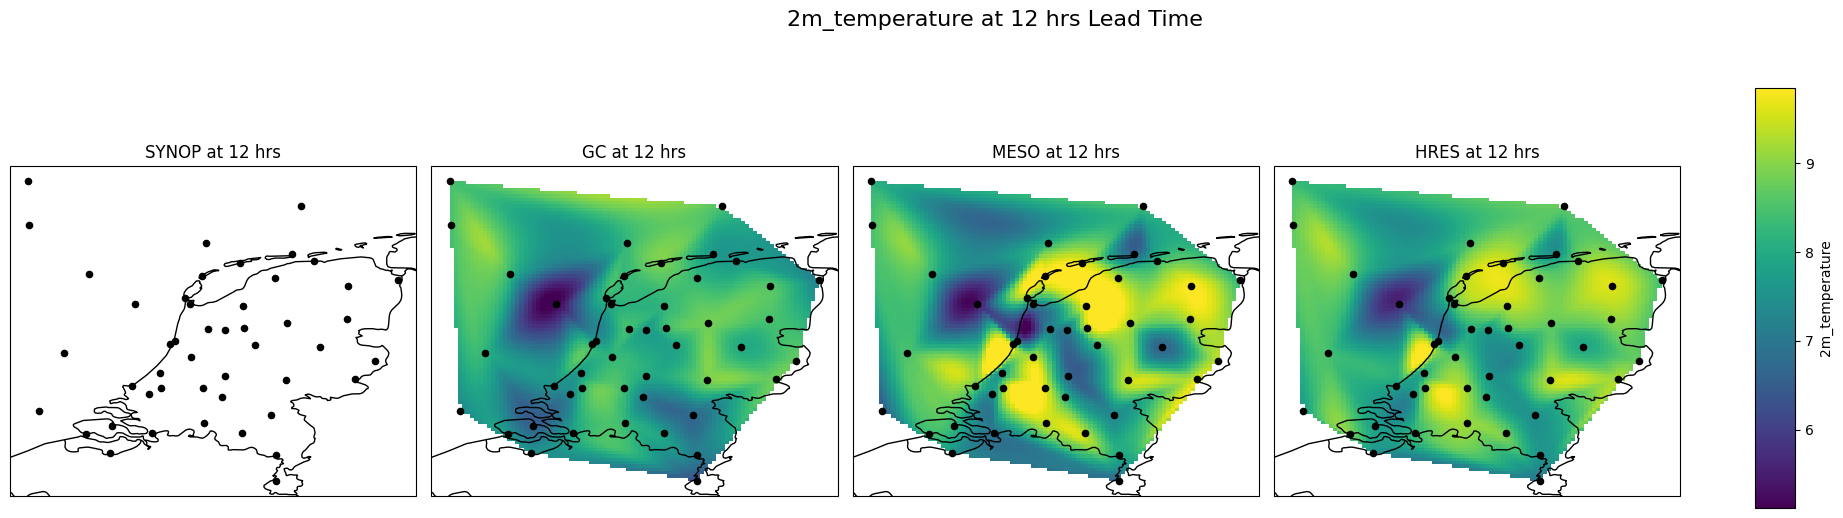

In [19]:
variable_name = '2m_temperature'
model_suffixes = ['synop', 'gc', 'meso', 'hres']  # Choose the models to plot
time_index = 5  # Index of the initialization time
prediction_timedelta_index = 1  # Index of the prediction_timedelta

plot_multiple_models(results, synop, variable_name, model_suffixes, time_index, prediction_timedelta_index, save_path=None)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_forecast_grid(results, synop_data, variable_name, model_suffixes, time_index, num_prediction_times, save_path=None):
    """
    Plots forecasts from multiple models over multiple prediction times in a grid layout using the Lambert Conformal Conic projection.
    """
    # Define the Lambert Conformal Conic projection centered over the Netherlands
    projection = ccrs.LambertConformal(
        central_longitude=5.5,
        central_latitude=52,
        standard_parallels=(49, 55)
    )

    # Get station locations
    station_lats = synop_data['lat'].isel(time=0).values
    station_lons = synop_data['lon'].isel(time=0).values

    # Determine the latitude and longitude bounds from the station data
    lat_min, lat_max = station_lats.min(), station_lats.max()
    lon_min, lon_max = station_lons.min(), station_lons.max()

    # Add padding to the bounds
    lat_padding = (lat_max - lat_min) * 0.1
    lon_padding = (lon_max - lon_min) * 0.1
    lat_min -= lat_padding
    lat_max += lat_padding
    lon_min -= lon_padding
    lon_max += lon_padding

    # Create grid to interpolate onto in geographic coordinates (longitude and latitude)
    grid_lon = np.linspace(lon_min, lon_max, 100)
    grid_lat = np.linspace(lat_min, lat_max, 100)
    grid_lon_grid, grid_lat_grid = np.meshgrid(grid_lon, grid_lat)

    # Get the prediction_timedelta values to plot
    prediction_timedelta_values = results['prediction_timedelta'].values[:num_prediction_times]

    num_models = len(model_suffixes)
    num_times = len(prediction_timedelta_values)

    # Prepare global vmin and vmax for consistent color scales
    all_data = []

    # Collect all data to determine global vmin and vmax
    for pt_index, prediction_timedelta in enumerate(prediction_timedelta_values):
        for model_suffix in model_suffixes:
            var_name = f"{variable_name}_{model_suffix}"
            data = results[var_name].isel(time=time_index, prediction_timedelta=pt_index).values
            all_data.append(data)

    # Compute global vmin and vmax
    vmin = np.nanmin(np.concatenate(all_data))
    vmax = np.nanmax(np.concatenate(all_data))

    # Adjust figure size if needed
    fig, axes = plt.subplots(
        nrows=num_times,
        ncols=num_models,
        figsize=(3.5*num_models, 4*num_times),  # Adjusted to reduce subplot size
        subplot_kw={'projection': projection}
    )

    # If only one row or column, ensure axes is 2D array
    if num_times == 1:
        axes = axes[np.newaxis, :]
    if num_models == 1:
        axes = axes[:, np.newaxis]

    for i, (pt_index, prediction_timedelta) in enumerate(zip(range(num_times), prediction_timedelta_values)):
        lead_hours = prediction_timedelta / np.timedelta64(1, 'h')

        for j, model_suffix in enumerate(model_suffixes):
            ax = axes[i, j]

            var_name = f"{variable_name}_{model_suffix}"
            data = results[var_name].isel(time=time_index, prediction_timedelta=pt_index).values

            # Interpolate data to grid
            grid_data = griddata(
                (station_lons, station_lats),  # Input coordinates
                data,                          # Values at input coordinates
                (grid_lon_grid, grid_lat_grid),# Points at which to interpolate
                method='linear'
            )

            # Plot data
            im = ax.pcolormesh(
                grid_lon_grid, grid_lat_grid,
                grid_data,
                transform=ccrs.PlateCarree(),
                shading='auto',
                cmap='viridis',
                vmin=vmin, vmax=vmax
            )

            # Plot station locations
            ax.scatter(
                station_lons, station_lats,
                color='black',
                s=10,
                transform=ccrs.PlateCarree(),
                zorder=5
            )

            # Add coastlines and borders
            ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
            ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), linewidth=0.5)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), linewidth=0.5)

            # Set extent in projection coordinates
            ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

            # Add title
            if i == 0:
                if model_suffix == 'synop':
                    ax.set_title(f"Observations", fontsize=12, fontweight='bold')
                else:
                    # Add model name at the top of each column
                    ax.set_title(f"{model_suffix.upper()}", fontsize=12)
            if j == 0:
                # Add lead time at the start of each row
                ax.text(
                    -0.1, 0.5,
                    f"{int(lead_hours)} hrs",
                    va='center', ha='right',
                    rotation=90,
                    transform=ax.transAxes,
                    fontsize=12
                )

            # Remove axis labels
            ax.set_xticks([])
            ax.set_yticks([])

      # Remove axis labels and spines to save space
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['geo'].set_visible(True)  # Remove the frame around the map

    # Adjust layout and spacing
    fig.subplots_adjust(
        left=0.10,
        right=0.85,
        top=0.92,
        bottom=0.08,
        wspace=0.01,  # Further reduce horizontal space
        hspace=0.01   # Further reduce vertical space
    )


    # Add a common colorbar
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label=variable_name)

    # Add a main title
    # turn datetime into a readable string keeping only the date
    time_str = str(results['time'].values[time_index])[:13]

    plt.suptitle(f"Forecasts of {variable_name} initialized at {time_str} UTC", fontsize=16)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=300)
        plt.close()
    else:
        plt.show()

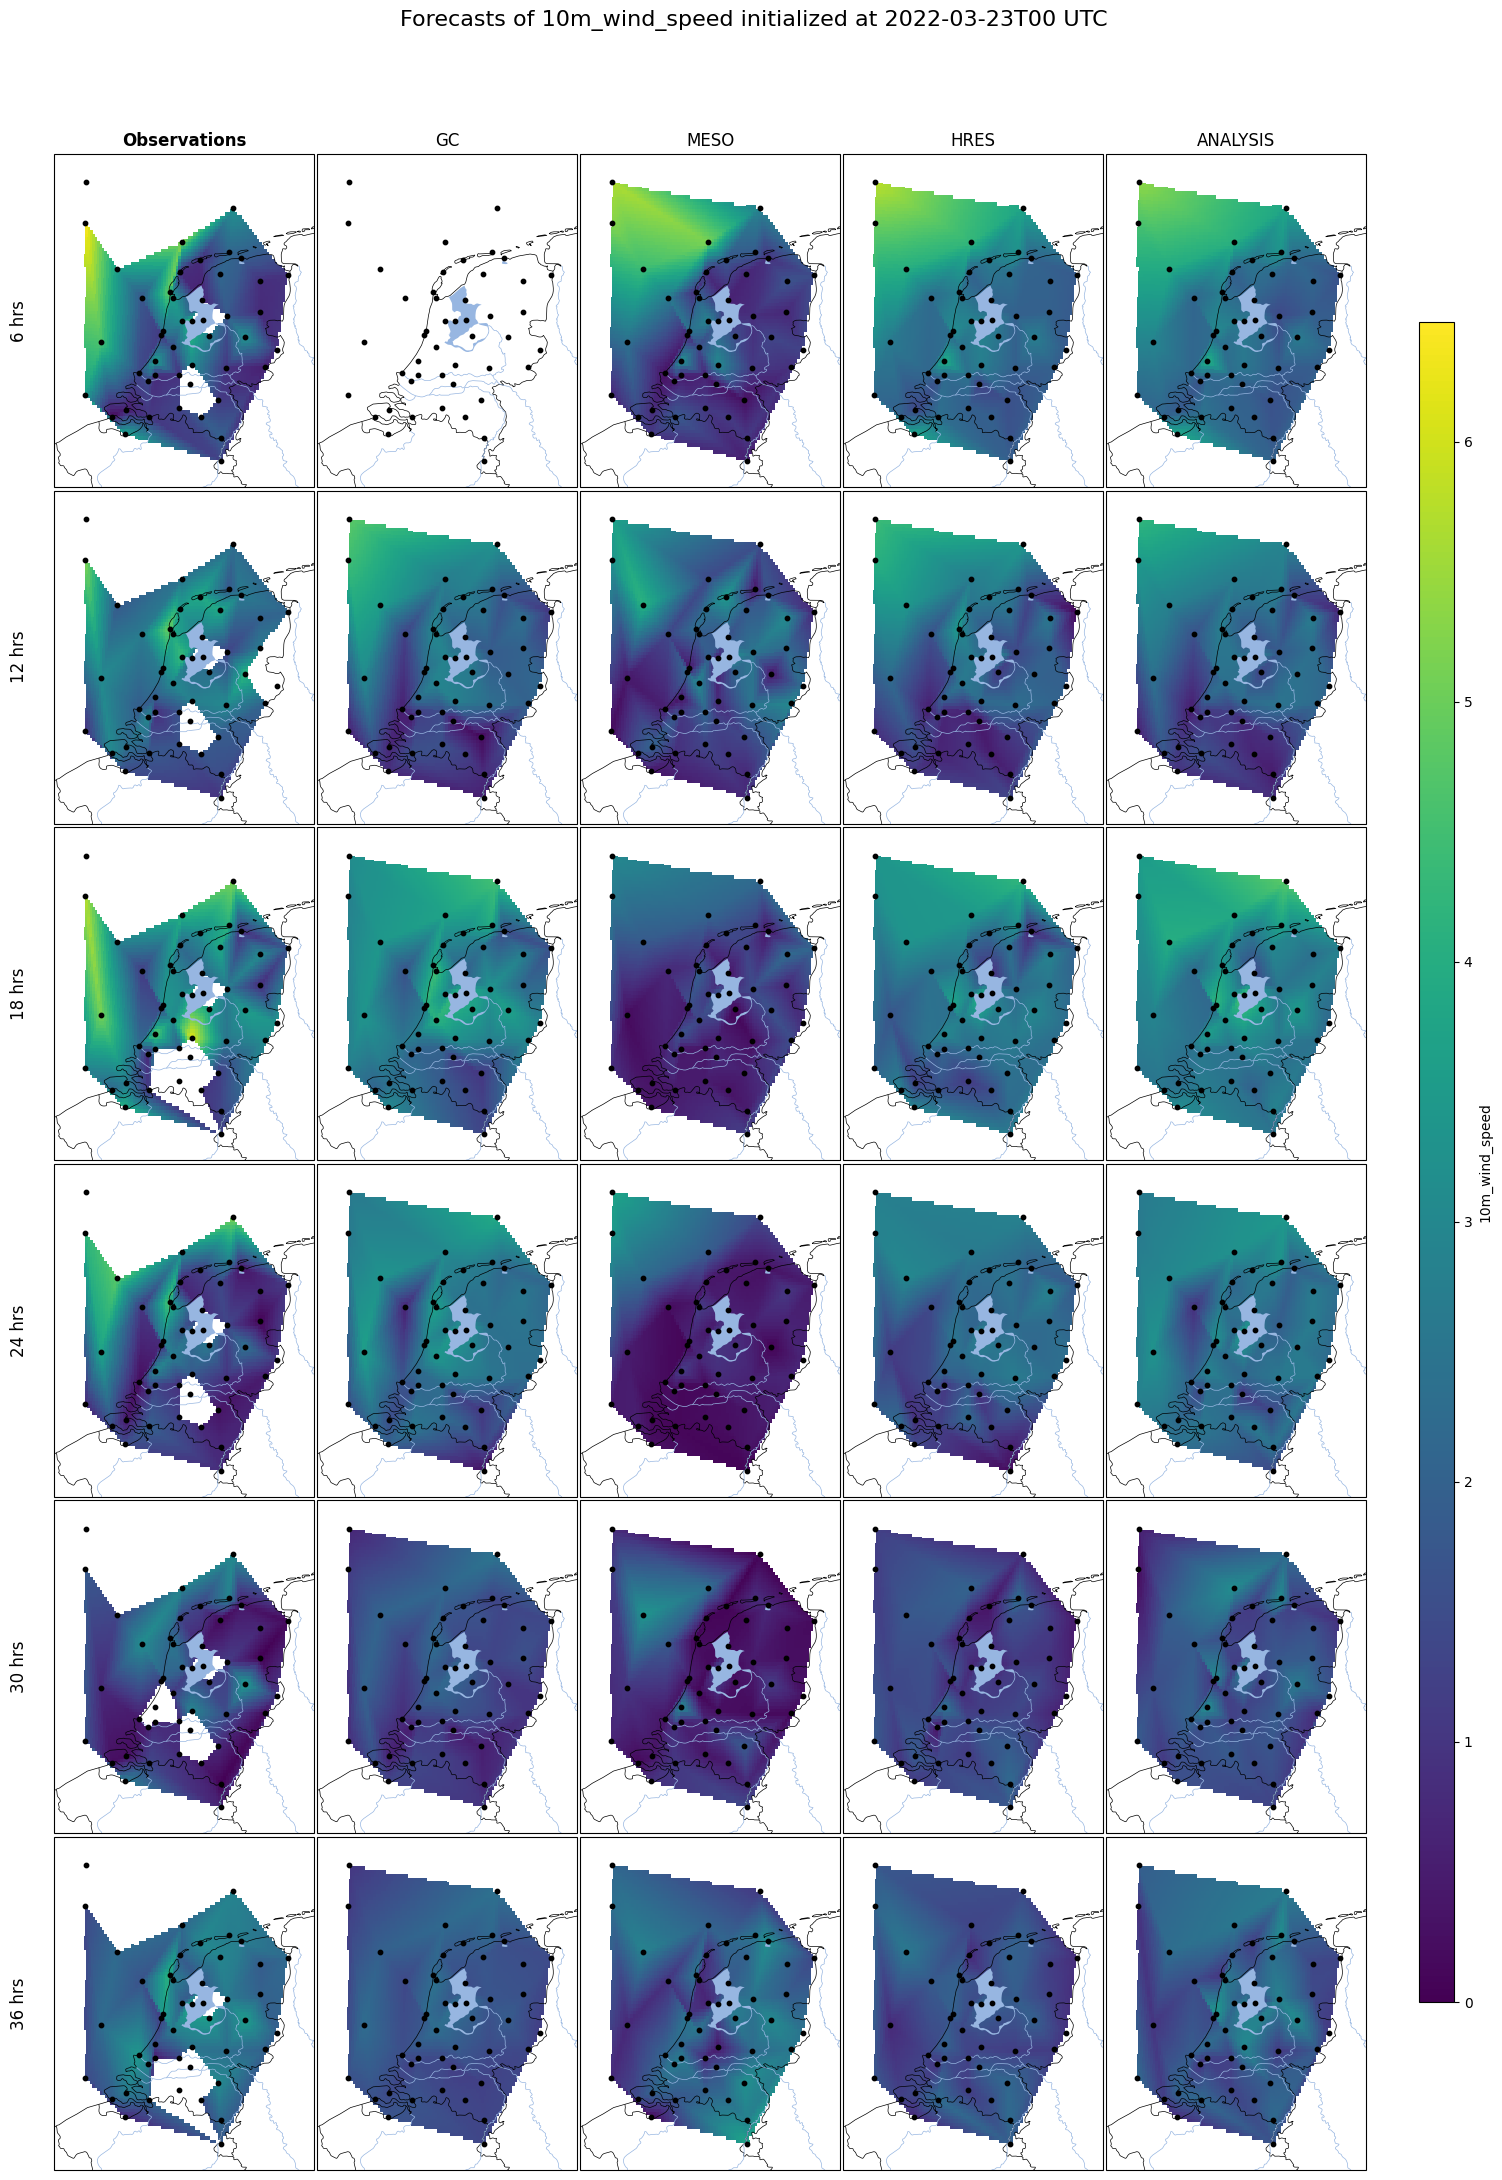

In [23]:
variable_name = '10m_wind_speed'
model_suffixes = ['synop','gc', 'meso', 'hres', 'analysis']
time_index = 70  # Index of the initialization time
date = str(results['time'].values[time_index])[:10]

num_prediction_times = 6  # Number of prediction_timedelta steps to plot

save_path = f'forecast_map_plots/forecast_map_grid_{num_prediction_times*6}hrs_{variable_name}_{date}.png'
save_path = None
plot_forecast_grid(results, synop, variable_name, model_suffixes, time_index, num_prediction_times, save_path=save_path)
